# NOAA Fisheries Steller Sea Lion Population Count

## Image Preprocessing
There needs to be preprocessing to reduce the size of images to fit into memory. This notebook assumes the images are all resized to 512x512. This can be done using ImageMagik
```sh
mogrify -resize 512x512! -format png -path test_images_512x512 Test/*.jpg
```

In [58]:
import keras
import cv2
import sys
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Input, concatenate, GlobalMaxPooling2D
from keras.models import Model
from keras import backend as K
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.optimizers import SGD

%matplotlib notebook

## Configuration

In [59]:
n_classes= 5            
batch_size= 20
epochs= 30                   
image_size= 512  
model_name= 'cnn' 

train_dir = '/media/bss/Ubuntu HDD/noaa-sealions/data_512/train/train'
validation_dir = '/media/bss/Ubuntu HDD/noaa-sealions/data_512/validation'
test_dir = '/media/bss/Ubuntu HDD/noaa-sealions/data_512/test'

ignore_list = pd.read_csv('../data/miss_class.txt')['train_id'].tolist()

# verify files
len(os.listdir(test_dir)), len(os.listdir(train_dir)), len(os.listdir(validation_dir))

(17745, 713, 178)

In [60]:
'''
Data loading function
'''
def load_data(dir_path):
    df = pd.read_csv('../data/train.csv')
    
    n_train_wValidation_images = 713
    n_train_images = 948
    
    image_list = []  
    y_list = []      

    #for i in range(0, n_train_wValidation_images):
    for idx, i in enumerate(os.listdir(train_dir)):
        name = i.replace('.png','')
        img_path = os.path.join(train_dir, str(i))
        img = cv2.imread(img_path)
        image_list.append(img)

        row = df.iloc[int(name)]

        y_row = np.zeros((5))
        y_row[0] = row['adult_males']
        y_row[1] = row['subadult_males']
        y_row[2] = row['adult_females']
        y_row[3] = row['juveniles']
        y_row[4] = row['pups']
        y_list.append(y_row)
    x_train = np.asarray(image_list)
    y_train = np.asanyarray(y_list)
    
    print('X Train: ' + str(x_train.shape) + '\nY Train: ' + str(y_train.shape))
    return x_train, y_train

In [61]:
'''
Load validation data
'''
def load_validation_data(dir_path):
    df = pd.read_csv('../data/train.csv')
    
    n_valid_images = 179  #948
    
    image_list = []
    y_list = []
    
    #for i in range(0, n_valid_images):
    for idx, i in enumerate(os.listdir(validation_dir)):
        name = i.replace('.png','')
        img_path = os.path.join(validation_dir, str(i)) # + '.png'
        img = cv2.imread(img_path)
        image_list.append(img)

        row = df.iloc[int(name)]

        y_row = np.zeros((5))
        y_row[0] = row['adult_males']
        y_row[1] = row['subadult_males']
        y_row[2] = row['adult_females']
        y_row[3] = row['juveniles']
        y_row[4] = row['pups']
        y_list.append(y_row)
    x_train = np.asarray(image_list)
    y_train = np.asanyarray(y_list)
    
    print('X Train: ' + str(x_train.shape) + '\nY Train: ' + str(y_train.shape))
    return x_train, y_train

## VGG16 Model

In [62]:
'''
'''
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(512, 512, 3))  #weights='imagenet'

In [63]:
model = Sequential()
model.add(conv_base)
model.add(Conv2D(512, (3,3), activation='relu'))
model.add(Conv2D(n_classes, (1,1), activation='relu'))
model.add(GlobalAveragePooling2D())

#model.add(Conv2D(n_classes, kernel_size=(3, 3), padding='same'))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

#model.add(GlobalAveragePooling2D())
'''
new test
'''
#model.add(Flatten())
#model.add(Dense(512))
#model.add(Dense(512, activation="relu"))
#model.add(Dense(5, activation='sigmoid'))
#model.add(Dropout(0.2))
#model.add(Dense(5))

#model.add(Activation('sigmoid'))
#model.add(Dense(5))

#sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=keras.losses.mean_squared_error, 
              optimizer=keras.optimizers.Adadelta(lr=0.01), metrics=['accuracy'])  # losses.mean_squared_error

print(model.summary())

#conv_base.trainable = False  # freeze weights = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    else:
        set_trainable = False
#conv_base_train.trainable = True
print('Number of trainable weights: ', len(model.trainable_weights))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 512)       2359808   
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 14, 5)         2565      
_________________________________________________________________
global_average_pooling2d_11  (None, 5)                 0         
Total params: 17,077,061
Trainable params: 17,077,061
Non-trainable params: 0
_________________________________________________________________
None
Number of trainable weights:  30


In [64]:
def train_vgg16_freezeweights(model):
    batch_size = 16
    x_train, y_train = load_data(os.path.join(train_dir, 'train'))  # '../data_512/' -or- train_dir
    validation_tuple = load_validation_data(validation_dir)
        
    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=80)
    
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                        steps_per_epoch = len(x_train) / batch_size, epochs = epochs, validation_data=validation_tuple)  #, validation_data=validation_tuple
    
    model.save('./models/' + model_name + 'vgg16_adadeltaLR.h5')
    
    return history

In [65]:
history = train_vgg16_freezeweights(model)

X Train: (713, 512, 512, 3)
Y Train: (713, 5)
X Train: (178, 512, 512, 3)
Y Train: (178, 5)
Epoch 1/30
45/44 [==============================] - 48s - loss: 1861.6134 - acc: 0.4717 - val_loss: 2222.7031 - val_acc: 0.4775
Epoch 2/30
45/44 [==============================] - 47s - loss: 1727.3481 - acc: 0.4682 - val_loss: 2302.8549 - val_acc: 0.4775
Epoch 3/30
45/44 [==============================] - 48s - loss: 1722.9100 - acc: 0.4650 - val_loss: 2296.0469 - val_acc: 0.4775
Epoch 4/30
45/44 [==============================] - 48s - loss: 1712.4543 - acc: 0.4672 - val_loss: 2254.1416 - val_acc: 0.4775
Epoch 5/30
45/44 [==============================] - 48s - loss: 1699.3482 - acc: 0.4703 - val_loss: 2250.1208 - val_acc: 0.4775
Epoch 6/30
45/44 [==============================] - 48s - loss: 1687.6570 - acc: 0.4679 - val_loss: 2266.5137 - val_acc: 0.4775
Epoch 7/30
45/44 [==============================] - 48s - loss: 1689.5853 - acc: 0.4682 - val_loss: 2281.1447 - val_acc: 0.4775
Epoch 8/30
4

## Model

In [ ]:
'''
Original model w/ dropout layers
try sigmoid
'''
def get_dropout_model():
    input_shape = (image_size, image_size, 3)
    
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.2))
    
    model.add(Conv2D(128, kernel_size = (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    #model.add(Dropout(0.2))
    
    model.add(Conv2D(n_classes, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.2))
    
    model.add(GlobalAveragePooling2D())
    #model.add(GlobalMaxPooling2D())
    
    print(model.summary())
    
    model.compile(loss = keras.losses.mean_squared_error,
                  metrics = ['accuracy'],
                  optimizer = keras.optimizers.Adadelta())  #keras.optimizers.Adam()
    return model

In [14]:
'''
Original model 
'''
def get_model():
    input_shape = (image_size, image_size, 3)
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
        
    model.add(Conv2D(n_classes, kernel_size=(3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(GlobalAveragePooling2D())
    
    print (model.summary())
    #sys.exit(0) #

    model.compile(loss=keras.losses.mean_squared_error,
            optimizer= keras.optimizers.Adagrad())
             
    return model

## Training

In [15]:
def train():
    model = get_model()# test_model() #get_dropout_model() #get_vgg16_model()
    
    x_train, y_train = load_data('../data_512/')  #'../data_512/' train_dir
    validation_tuple = load_validation_data(validation_dir)
        
    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, 
                                 rotation_range=90)
    
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                        steps_per_epoch = len(x_train) / batch_size, 
                                  epochs = epochs, validation_data=validation_tuple)  #, validation_data=validation_tuple
    
    model.save('./models/' +'original_model.h5')
    
    return history

In [16]:
history = train()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 512, 512, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 512, 512, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
activation_6 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 128)     73856     
__________

## Evaluation

In [25]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


<IPython.core.display.Javascript object>


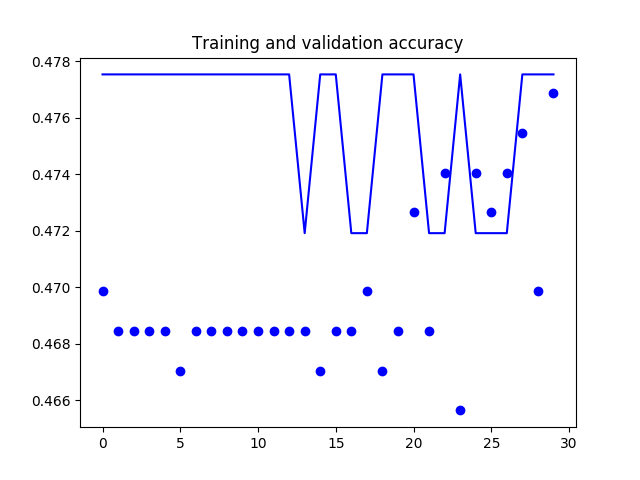

<IPython.core.display.Javascript object>


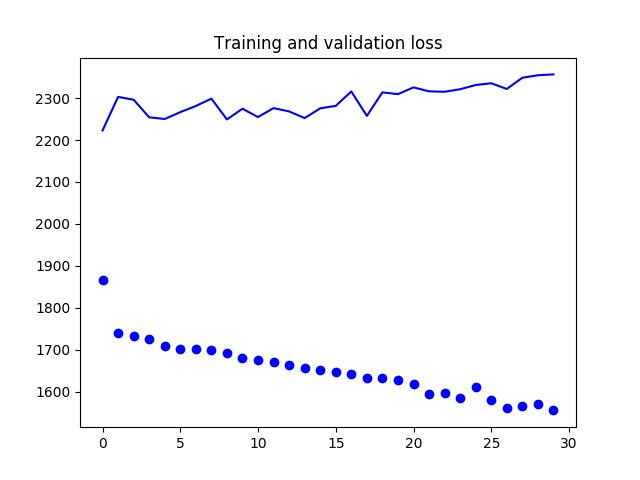

In [66]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')

plt.show()
#plt.savefig('150e_wDropout_mon.png')

In [ ]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Submission

In [ ]:
'''
Removing mismatched images, reading in images w/ corresponding attr
'''
def load_all_data(dir_path):
    df = pd.read_csv('../data/train.csv')
    
    ignore_list = read_ignore_list()
    n_train_images = 948
    
    image_list = []
    y_list = []
    
    for i in range(0, n_train_images):
        img_path = os.path.join(dir_path, str(i) + '.png')
        img = cv2.imread(img_path)
        print('Image shape: ' + str(img.shape))

        image_list.append(img)

        row = df.ix[i]

        y_row = np.zeros((5))
        y_row[0] = row['adult_males']
        y_row[1] = row['subadult_males']
        y_row[2] = row['adult_females']
        y_row[3] = row['juveniles']
        y_row[4] = row['pups']
        y_list.append(y_row)
    x_train = np.asarray(image_list)
    y_train = np.asanyarray(y_list)
    
    print('X Train: ' + str(x_train.shape))
    print('Y Train: ' + str(y_train.shape))

    return x_train, y_train

In [ ]:
'''
train model on full data
'''
def train_full():
    model = get_vgg16_model()#get_dropout_model()
    
    x_train, y_train = load_all_data('../data_512/all_data/')  #'../data_512/' train_dir
        
    datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, 
                                 rotation_range=80)
    
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=8),steps_per_epoch = len(x_train) / batch_size, epochs = epochs)
    
    model.save('./models/' + model_name + str(datetime.datetime.now())[:-7] + 'transvgg16.h5')
    
    return history

In [ ]:
history = train_full()

In [67]:
def create_submission():
    model = load_model('./models/cnnvgg16_adadeltaLR.h5')
    
    n_test_images = 18636
    
    pred_arr = np.zeros((n_test_images, n_classes), np.int32)
    
    for k in range(0, n_test_images):
        image_path = '../data_512/' + str(k) + '.png'
        
        img = cv2.imread(image_path)
        img = img[None, ...]
        pred = model.predict(img).astype(int)
        
        pred_arr[k,:] = pred
    
    print('Pred arr: ' + str(pred_arr.shape))
    
    pred_arr = pred_arr.clip(min=0)
    
    df_submission = pd.DataFrame()
    df_submission['test_id'] = range(0, n_test_images)
    df_submission['adult_males'] = pred_arr[:,0]
    df_submission['subadult_males'] = pred_arr[:,1]
    df_submission['adult_females'] = pred_arr[:,2]
    df_submission['juveniles'] = pred_arr[:,3]
    df_submission['pups'] = pred_arr[:,4]
    
    df_submission.to_csv('./submissions/' + 'vgg16_adadeltalr_submission.csv', index = False)

In [ ]:
create_submission()

In [ ]:
# sample 
from keras.applications import VGG16

def get_vgg16_model():
    batch_size= 8
    vgg16 = keras.applications.vgg16.VGG16(include_top=False, 
                                           weights='imagenet', 
                                           input_shape=(image_size,image_size,3))

    x= Conv2D(n_classes, (1, 1), activation='relu')(vgg16.output)
    x= GlobalAveragePooling2D()(x)

    model = Model(vgg16.input, x)

    print(model.summary())

    history = model.compile(loss=keras.losses.mean_squared_error,
            optimizer= keras.optimizers.Adadelta())

    return model

## Resources

https://www.kaggle.com/c/noaa-fisheries-steller-sea-lion-population-count/

https://www.kaggle.com/radustoicescu/use-keras-to-classify-sea-lions-0-91-accuracy

https://www.kaggle.com/radustoicescu/count-the-sea-lions-in-the-first-image

https://github.com/mrgloom/Kaggle-Sea-Lions-Solution/blob/master/01-Image%20level%20regression/run_me.py

http://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/